# Using EcoFOCIpy to process raw field data

## Mooring / Timeseries Data

Basic workflow for each instrument grouping is *(initial archive level)*:
- Parse data from raw files into pandas dataframe
- output initial files (pandas->csv) **ERDDAP NRT** when no meta data is added

Convert to xarray dataframe for all following work *(working or final data level):
- TODO: Add metadata from instrument yaml files and/or header info
- ingest metadata from deployment/recovery records or cast logs
- process data beyond simple file translate
- apply any calibrations or corrections
    + field corrections
    + offsets
    + instrument compensations
    + some QC were available... this would be old-school simple bounds mostly
- adjust time bounds and sample frequency (xarray dataframe)
- save as CF netcdf via xarray: so many of the steps above are optional
    + **ERDDAP NRT** if no corrections, offsets or time bounds are applied but some meta data is
    + **Working and awaiting QC** has no ERDDAP representation and is a holding spot
    + **ERDDAP Final** fully calibrated, qc'd and populated with meta information

Plot for preview and QC
- preview images (indiv and/or collectively)
- manual qc process
- automated qc process ML/AI

Further refinenments for ERDDAP hosting:


## Example below is for Meterological Data as it comes off the pico/RUDICS system.

Raw files had been reinterpreted

In [3]:
import numpy as np
import pandas as pd
import xarray as xa
import yaml
import glob

import EcoFOCIpy.io.sbe_parser as sbe_parser #<- instrument specific
import EcoFOCIpy.io.ncCFsave as ncCFsave
import EcoFOCIpy.metaconfig.load_config as load_config

The sample_data_dir should be included in the github package but may not be included in the pip install of the package

## Simple Processing - first step

In [4]:
sample_data_dir = '/Users/bell/Programs/EcoFOCIpy/'
user_data_dir = '/Users/bell/ecoraid/2018/Moorings/18mtitaepr1a/'

In [46]:
###############################################################
# edit to point to {instrument sepcific} raw datafile 
datafile = user_data_dir+'initial_archive/erddap/met/18mtitaepr1a_met.nc'
instrument = 'rudics_met'
mooring_meta_file = user_data_dir+'logs/18MTITAEPR-1A.yaml'
inst_meta_file = sample_data_dir+'staticdata/instr_metaconfig/wxt_cf.yaml'
institution_meta_file = sample_data_dir+'staticdata/institutional_meta_example.yaml' #include uaf?
inst_shortname = 'rudics_met'
###############################################################

#init and load location - this mooring is unique in that it broke free and drifted
gps = user_data_dir+'raw/location.csv'
gps_df = pd.read_csv(gps, parse_dates=True, index_col='Data Date (UTC)')

#init and load data
met_df=xa.load_dataset(datafile)
met_df = met_df.to_dataframe()

met_df = met_df[~met_df.duplicated()]
met_df = met_df.sort_index(ascending=True)

In [60]:
gps_df = gps_df.resample('10min').mean(numeric_only=True).ffill()
gps_df.columns

Index(['Speed', 'SATNUM', 'HDOP', 'GPS Accuracy', 'Time To First Fix',
       'Battery Voltage', 'Temperature', 'Event', 'lon', 'lat'],
      dtype='object')

In [54]:
met_df.columns

Index(['wind_speed', 'northward_wind', 'latitude', 'longitude',
       'air_pressure_at_sealevel', 'relative_humidity', 'air_temperature',
       'wind_from_direction', 'eastward_wind', 'station_id'],
      dtype='object')

In [55]:
met_df = met_df.drop(columns=['latitude','longitude'])

In [66]:
met_df = pd.merge(met_df,gps_df[['lon','lat']],left_index=True,right_index=True,how='left')



In [77]:
met_df.index = met_df.index.rename('date_time')
met_df = met_df.rename(columns={'air_pressure_at_sealevel':'pressure',
                                'Temperature':'PAR_Temp',
                                  'air_temperature':'temperature',
                                  'U':'northward_wind',
                                  'V':'eastward_wind',
                                  'Wind_Speed':'wind_speed',
                                  'Gust':'wind_speed_gust',
                                  'relative_humidity':'relative_humidity',
                                'wind_from_direction':'wind_direction',
                                'ShortWaveRad':'swrad',
                                'PAR':'par',
                                'lon':'longitude',
                                'lat':'latitude'
                                  })
met_df.sample()

,wind_speed,northward_wind,pressure,relative_humidity,temperature,wind_direction,eastward_wind,station_id,longitude,latitude
date_time,,,,,,,,,,
2018-05-10 21:10:00,4.0,-3.8,997.97998,95.919998,1.7,159.800003,1.4,b'18MTITAEPR1A',NaN,NaN


In [78]:
#wrap the plot in image settings for visual appeal
# may be able to make this cleaner or just a preset
%run '../../../settings/mpl_plot_settings.py'

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter
import matplotlib.ticker as ticker


<Figure size 640x480 with 0 Axes>

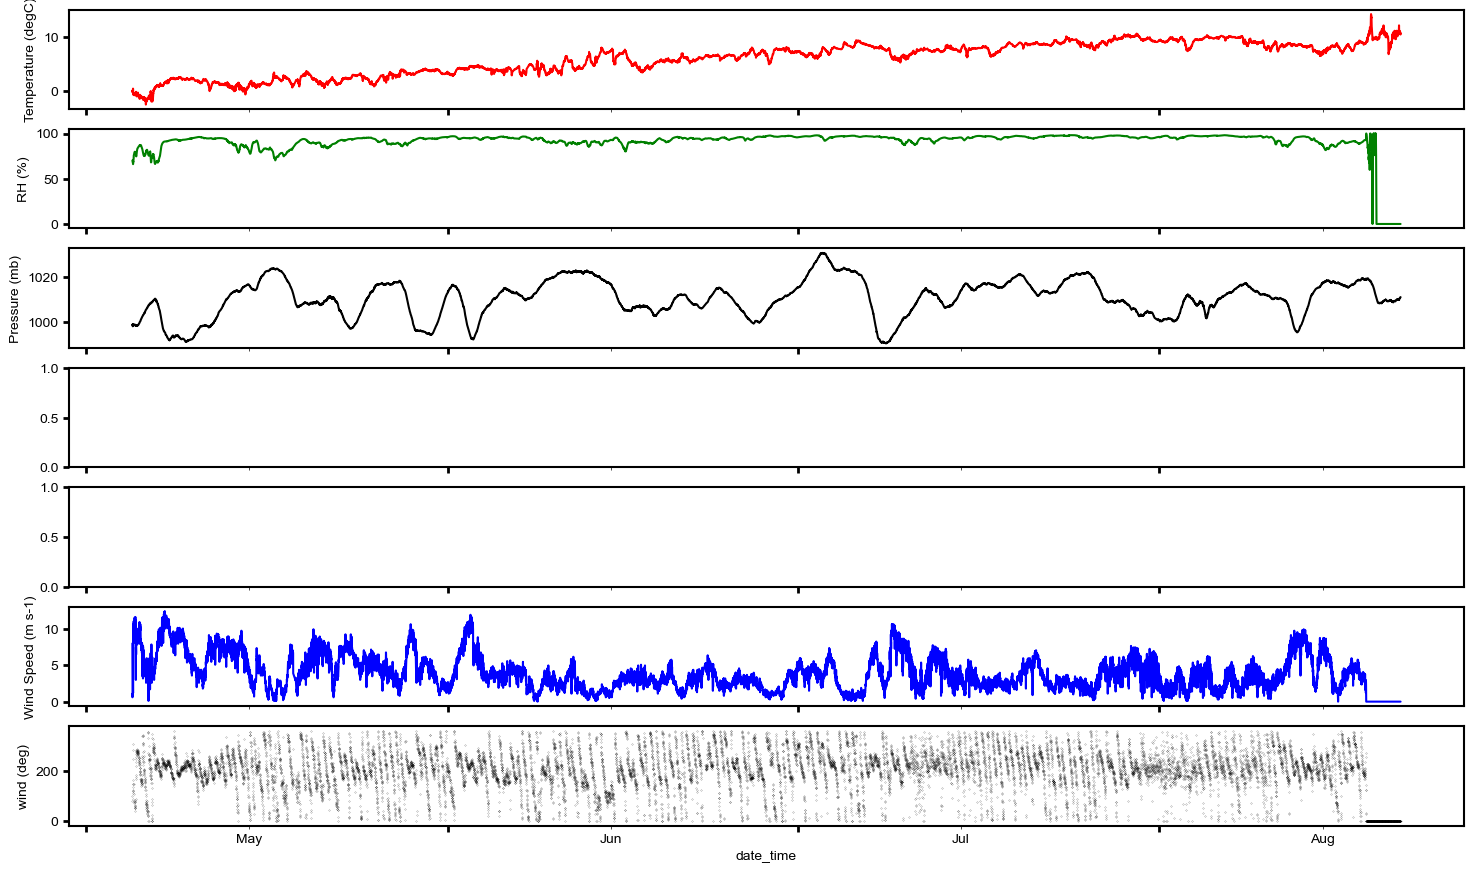

In [79]:
fig, ax = plt.subplots(7,figsize=(18, 12),sharex=True)
met_df.temperature.dropna().plot(ax=ax[0],c='r')
ax[0].set_ylabel('Temperature (degC)')
met_df.relative_humidity.dropna().plot(ax=ax[1],c='g')
ax[1].set_ylabel('RH (%)')
met_df.pressure.dropna().plot(ax=ax[2],c='k')
ax[2].set_ylabel('Pressure (mb)')
try:
    met_df.ShortWaveRad.dropna().plot(ax=ax[3],c='y')
    ax[3].set_ylabel('W m-2')
except:
    pass
try:
    met_df.PAR.dropna().plot(ax=ax[4],c='orange')
    ax[4].set_ylabel('PAR (micromole m-2 s-1)')
except:
    pass
met_df['wind_speed'].dropna().plot(ax=ax[5],c='b')
# met_df['Gust'].dropna().plot(ax=ax[5],c='k',style='.',markersize=.25)
ax[5].set_ylabel('Wind Speed (m s-1)')
met_df['wind_direction'].dropna().plot(ax=ax[6],c='k',style='.',markersize=.25)
ax[6].set_ylabel('wind (deg)')

ax[2].xaxis.set_minor_locator(DayLocator(bymonthday=15))
ax[2].xaxis.set_major_locator(DayLocator(bymonthday=1))
ax[2].xaxis.set_minor_formatter(DateFormatter('%b'))
ax[2].xaxis.set_major_formatter(DateFormatter(''))

In [80]:
## change variable names if needed to match TELOS yaml expectations

In [81]:
## Modify the raw file for whatever remaing QC you want to apply

## Add Deployment meta information

Two methods are available (if comming from python2 world - ordereddict was important... in py38 a dictionary is inherently ordered)

In [82]:
#just a dictionary of dictionaries - simple
with open(mooring_meta_file) as file:
    mooring_config = yaml.full_load(file)

In [83]:
#just a dictionary of dictionaries - simple
with open(institution_meta_file) as file:
    institution_config = yaml.full_load(file)

In [84]:
with open(inst_meta_file) as file:
    inst_config = yaml.full_load(file)

In [85]:
# Add meta data and prelim processing based on meta data
# Convert to xarray and add meta information - save as CF netcdf file
# pass -> data, instmeta, depmeta
met_wop_nc = ncCFsave.EcoFOCI_CFnc(df=met_df, 
                                instrument_yaml=inst_config, 
                                operation_yaml=mooring_config,
                                operation_type='mooring', 
                                instrument_id=instrument, 
                                inst_shortname=inst_shortname)
met_wop_nc

At this point, you could save your file with the `.xarray2netcdf_save()` method and have a functioning dataset.... but it would be very simple with no additional qc, meta-data, or tuned parameters for optimizing software like ferret or erddap.

In [87]:
# expand the dimensions and coordinate variables
# renames them appropriatley and prepares them for meta-filled values
# met_wop_nc.expand_dimensions()

In [88]:
met_wop_nc.variable_meta_data(variable_keys=list(met_df.columns.values),drop_missing=True)
# met_wop_nc.temporal_geospatioal_meta_data(depth='actual')
#adding dimension meta needs to come after updating the dimension values... BUG?
met_wop_nc.dimension_meta_data(variable_keys=['depth','latitude','longitude'])

The following steps can happen in just about any order and are all meta-data driven.  Therefore, they are not required to have a functioning dataset, but they are required to have a well described dataset

In [89]:
#add global attributes
met_wop_nc.deployment_meta_add()
met_wop_nc.get_xdf()

#add instituitonal global attributes
met_wop_nc.institution_meta_add(institution_yaml=institution_config)

#add instrument global attributes
# met_wop_nc.instrument_meta_data()

#add creation date/time - provenance data
met_wop_nc.provinance_meta_add()

#provide intial qc status field
met_wop_nc.qc_status(qc_status='unknown')

In [90]:
met_wop_nc.autotrim_time()

<xarray.Dataset> Size: 786kB
Dimensions:            (depth: 1, time: 15119)
Coordinates:
  * time               (time) datetime64[ns] 121kB 2018-05-05T02:10:00 ... 20...
  * depth              (depth) float64 8B 1e+35
Data variables:
    wind_speed         (depth, time) float32 60kB 9.7 11.1 10.4 ... 2.4 0.0 0.0
    northward_wind     (depth, time) float32 60kB -3.2 2.1 2.8 ... -0.7 0.0 0.0
    pressure           (depth, time) float32 60kB 998.6 998.7 ... 1.019e+03
    relative_humidity  (depth, time) float32 60kB 71.86 73.2 ... 100.0 100.0
    temperature        (depth, time) float32 60kB -0.69 -0.39 ... 8.91 9.09
    wind_direction     (depth, time) float32 60kB 109.2 79.1 74.4 ... 0.0 0.0
    eastward_wind      (depth, time) float32 60kB 9.2 10.9 10.0 ... -2.3 0.0 0.0
    longitude          (depth, time) float64 121kB nan nan nan ... -172.6 -172.6
    latitude           (depth, time) float64 121kB nan nan nan ... 60.63 60.63
Attributes: (12/29)
    MooringID:                              18MTITAEPR-1A
    platform_deployment_date:               2018-05-05T02:10:00Z
    platform_deployment_cruise_name:        DY1805
    platform_recovery_date:                 2018-08-18T17:54:00Z
    platform_recovery_cruise_name:          Fairweather
    platform_deployment_recovery_comments:  Short all Eco-Fluorometers
\nRemo...
    ...                                     ...
    citation:                               
    acknowledgement:                        
    date_created:                           2025-04-02T14:09:57Z
    date_modified:                          
    QC_indicator:                           unknown
    history:                                Trimmed to deployment.

## Save CF Netcdf files

Currently stick to netcdf3 classic... but migrating to netcdf4 (default) may be no problems for most modern purposes.  Its easy enough to pass the `format` kwargs through to the netcdf api of xarray.

In [91]:
# combine trim (not mandatory) and filename together (saves to test.nc without name)

depth = ''
# mooring_yaml['Instrumentation'][self.instrument_id]['DesignedDepth'])).zfill(4) #<-- alternative
filename = "".join(mooring_config['MooringID'].split('-')).lower()+'_'+inst_shortname+'.nc'
met_wop_nc.xarray2netcdf_save(xdf = met_wop_nc.autotrim_time(),
                           filename=filename,format="NETCDF3_CLASSIC")

met_wop_nc.autotrim_time().to_dataframe().to_csv(filename.replace('.nc','.csv'))

/Users/bell/src/ecofocipy/src/EcoFOCIpy/io/ncCFsave.py:320: UserWarning: Times can't be serialized faithfully to int64 with requested units 'days since 1900-01-01'. Resolution of 'minutes' needed. Serializing times to floating point instead. Set encoding['dtype'] to integer dtype to serialize to int64. Set encoding['dtype'] to floating point dtype to silence this warning.
  xdf.to_netcdf(filename,format=kwargs['format'],encoding={'time':{'units':'days since 1900-01-01'}})
